In [ ]:
import os
import random
import torch
import numpy as np
from scipy.linalg import circulant
from tqdm import tqdm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from results_helper import get_avg_miscoverage_streak_len, get_avg_miscoverage_streak_len_aux2
from utils.TSQR import batch_pinball_loss

matplotlib.rc('font', **{'size': 10})
SAVE_FIG = True
def savefig(title, fig=None):
    if SAVE_FIG:
        fig = fig if fig else plt.gcf()
        fig.savefig(f'./figures/{title}.png', bbox_inches='tight', dpi=300)
sns.set_style("whitegrid", {'axes.grid' : False})

# Run reproducible_experiments/run_single_response_experiments.py

In [2]:
if not os.path.exists('figures'):
    os.mkdir('figures')

In [3]:
def local_coverage_level(coverage, test=None, plot=False):
    local_size = 200
    coverage_mat = circulant(coverage)
    local_coverage = coverage_mat[:local_size // 2, local_size // 2:-local_size // 2].mean(axis=0)
    std = np.std(local_coverage)
    if plot:
        assert test
        plt.plot(range(len(local_coverage)), local_coverage, label=test+f' std={np.round(std, 3)}')
        plt.legend()
    return local_coverage

def local_msl2_level(coverage, test=None, plot=False):
    local_size = 200
    msls = []
    for i in range(local_size // 2, len(coverage)-local_size // 2):
        msls.append(get_avg_miscoverage_streak_len_aux2(coverage[i:i+local_size]))
    
    if plot:
        assert test
        plt.plot(range(len(msls)), msls, label=test)
        plt.legend()
    return msls


def delta_coverage(all_v):
    coverages = []
    for day in range(7):
        v = all_v[day::7]
        coverages.append(abs(v.float().mean().item() - 0.9))
    return np.mean(coverages)

def delta_msl2(all_v):
    msl2s = []
    for day in range(7):
        v = all_v[day::7]
        msl2s.append(abs(get_avg_miscoverage_streak_len_aux2(v) - 0.111111111111111))
    return np.mean(msl2s)

In [4]:
import glob

tests_path = glob.glob('results/test/*/*/calibrated_*/seed*.pt')
tests_path[:10]

['results/test/real/energy/calibrated_MSL_RISK_LossAwareExpPhiFunction_CoverageScoreFunction_baseline_all_q=0_lstm_hd=128_lstm_nl=1_lstm_in_hd=[32, 64]_lstm_out_hd=[64, 32]_lr=0.0001_gamma=0.025/seed=0.pt',
 'results/test/real/energy/calibrated_MSL_RISK_LossAwareExpPhiFunction_CoverageScoreFunction_baseline_all_q=0_lstm_hd=128_lstm_nl=1_lstm_in_hd=[32, 64]_lstm_out_hd=[64, 32]_lr=0.0001_gamma=0.025/seed=6.pt',
 'results/test/real/energy/calibrated_MSL_RISK_LossAwareExpPhiFunction_CoverageScoreFunction_baseline_all_q=0_lstm_hd=128_lstm_nl=1_lstm_in_hd=[32, 64]_lstm_out_hd=[64, 32]_lr=0.0001_gamma=0.025/seed=2.pt',
 'results/test/real/energy/calibrated_MSL_RISK_LossAwareExpPhiFunction_CoverageScoreFunction_baseline_all_q=0_lstm_hd=128_lstm_nl=1_lstm_in_hd=[32, 64]_lstm_out_hd=[64, 32]_lr=0.0001_gamma=0.025/seed=11.pt',
 'results/test/real/energy/calibrated_MSL_RISK_LossAwareExpPhiFunction_CoverageScoreFunction_baseline_all_q=0_lstm_hd=128_lstm_nl=1_lstm_in_hd=[32, 64]_lstm_out_hd=[64, 32

In [5]:
import re

d = {
    'name': [], 'method': [], 'risk': [], 'dataset': [], 'v_mean': [], 'msl': [], 'msl2': [], 'coverage_length_corr': [], 'lower_q_mean': [],
    'upper_q_mean': [], 'length_mean': [], 'length_std': [], 'length_diff_mean': [], 'lower_pinball_loss': [], 'upper_pinball_loss': [], 'avg_pinball_loss': [],
    'val_lower_pinball_loss': [], 'val_upper_pinball_loss': [], 'val_avg_pinball_loss': [], 'delta_coverage': [], 'delta_msl2': [], 'gamma': [],
}

for test in tqdm(tests_path):
    y, upper_q,lower_q = torch.load(test)
    y, upper_q, lower_q = y.cpu(), upper_q.cpu(), lower_q.cpu()
    v = (y <= upper_q) & (y >= lower_q)
    
    if '/real/' in test:
        d['name'].append('{}_{}'.format(*re.findall(r'real/(.+)/calibrated_(.+)_baseline', test)[0]))
        d['dataset'].append(re.findall(r'real/(.+)/calibrated', test)[0])
    else:
        d['name'].append('{}'.format(re.findall(r'calibrated_(.+)_baseline.*seed', test)[0]))
        d['dataset'].append('syn')

    gamma = re.findall(r'gamma=(.+)/', test)[0].split('_')[0]
    d['gamma'].append(gamma)
    d['name'][-1] += '_gamma=' + gamma
    
    if 'ACI+CQR' in test:
        d['method'].append('ACI')
    elif 'RCI+CQR' in test:
        d['method'].append('RCI_with_cal')
    else:
        d['method'].append(re.findall(r'calibrated.*RISK_(.*)_baseline', test)[0])
    
    if 'ACI+CQR' in d['name'][-1] or 'RCI+CQR' in test:
        d['risk'].append('COVERAGE')
    else:
        d['risk'].append(re.findall(r'calibrated_(.+)_RISK', test)[0])
    d['v_mean'].append(float(v.float().mean()))
    d['msl'].append(get_avg_miscoverage_streak_len(y, upper_q,lower_q))
    d['msl2'].append(get_avg_miscoverage_streak_len_aux2(v))
    d['lower_q_mean'].append(float(lower_q.float().mean()))
    d['upper_q_mean'].append(float(upper_q.float().mean()))
    length = upper_q-lower_q
    length = torch.where(length>0, length, torch.tensor(0.0))
    d['coverage_length_corr'].append(np.abs(np.corrcoef((~v).float(),length)[0, 1]))
    d['length_mean'].append(float(length.float().mean()))
    d['length_std'].append(float(torch.std(length, unbiased=False)))
    length_diffs = (length[1:] - length[:-1]).abs()
    d['length_diff_mean'].append(float(length_diffs.mean()))
    
    lower_pinball_loss = float(batch_pinball_loss(0.05, lower_q, y))
    upper_pinball_loss = float(batch_pinball_loss(0.95, upper_q, y))
    avg_pinball_loss = (lower_pinball_loss+upper_pinball_loss)/2
    d['lower_pinball_loss'].append(lower_pinball_loss)
    d['upper_pinball_loss'].append(upper_pinball_loss)
    d['avg_pinball_loss'].append(avg_pinball_loss)
    
    parts = test.split('/')
    parts[-1] = 'train_' + parts[-1]
    val_y, val_upper_q,val_lower_q = torch.load('/'.join(parts))
    val_y, val_upper_q, val_lower_q = val_y.cpu(), val_upper_q.cpu(), val_lower_q.cpu()
    val_lower_pinball_loss = float(batch_pinball_loss(0.05, val_lower_q, val_y))
    val_upper_pinball_loss = float(batch_pinball_loss(0.95, val_upper_q, val_y))
    val_avg_pinball_loss = (val_lower_pinball_loss+val_upper_pinball_loss)/2
    d['val_lower_pinball_loss'].append(lower_pinball_loss)
    d['val_upper_pinball_loss'].append(upper_pinball_loss)
    d['val_avg_pinball_loss'].append(avg_pinball_loss)
    
    d['delta_coverage'].append(delta_coverage(v))
    d['delta_msl2'].append(delta_msl2(v))
    
    

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
df = pd.DataFrame.from_dict(d)
df

 29%|██▉       | 3037/10400 [24:36<1:00:55,  2.01it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 10400/10400 [1:25:10<00:00,  2.04it/s]


,name,method,risk,dataset,v_mean,msl,msl2,coverage_length_corr,lower_q_mean,upper_q_mean,length_mean,length_std,length_diff_mean,lower_pinball_loss,upper_pinball_loss,avg_pinball_loss,val_lower_pinball_loss,val_upper_pinball_loss,val_avg_pinball_loss,delta_coverage,delta_msl2,gamma
0,energy_MSL_RISK_LossAwareExpPhiFunction_Covera...,LossAwareExpPhiFunction_CoverageScoreFunction,MSL,energy,0.913166,1.281761,0.112484,0.103337,31.565323,167.362350,135.797012,108.688759,30.236580,4.342865,9.408765,6.875815,4.342865,9.408765,6.875815,0.013166,0.010548,0.025
1,energy_MSL_RISK_LossAwareExpPhiFunction_Covera...,LossAwareExpPhiFunction_CoverageScoreFunction,MSL,energy,0.910524,1.247031,0.112825,0.096965,31.411722,167.223129,135.811401,105.962456,30.995867,4.256388,9.399396,6.827892,4.256388,9.399396,6.827892,0.010916,0.010926,0.025
2,energy_MSL_RISK_LossAwareExpPhiFunction_Covera...,LossAwareExpPhiFunction_CoverageScoreFunction,MSL,energy,0.910439,1.261705,0.112910,0.104187,30.481621,168.557053,138.075455,109.413490,31.352135,4.279885,9.573734,6.926810,4.279885,9.573734,6.926810,0.010491,0.011182,0.025
3,energy_MSL_RISK_LossAwareExpPhiFunction_Covera...,LossAwareExpPhiFunction_CoverageScoreFunction,MSL,energy,0.911291,1.248201,0.112825,0.091307,30.126137,166.816483,136.690369,112.370613,31.466164,4.163215,9.317594,6.740404,4.163215,9.317594,6.740404,0.011513,0.012886,0.025
4,energy_MSL_RISK_LossAwareExpPhiFunction_Covera...,LossAwareExpPhiFunction_CoverageScoreFunction,MSL,energy,0.909672,1.233993,0.112484,0.081691,33.935677,163.097244,129.161575,107.606941,30.420633,3.987695,9.264398,6.626047,3.987695,9.264398,6.626047,0.011257,0.011268,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10395,wind_MSL_RISK_ExpPhiFunction_gamma=0.1,ExpPhiFunction,MSL,wind,0.903083,1.149209,0.111000,0.129715,1582.797607,2308.735107,725.954529,614.312134,82.436424,28.912777,29.929068,29.420922,28.912777,29.929068,29.420922,0.006100,0.006778,0.1
10396,wind_MSL_RISK_ExpPhiFunction_gamma=0.1,ExpPhiFunction,MSL,wind,0.901583,1.134486,0.111000,0.126661,1609.720215,2313.239990,703.530151,546.473267,82.789993,27.645706,29.234552,28.440129,27.645706,29.234552,28.440129,0.007965,0.009943,0.1
10397,wind_MSL_RISK_ExpPhiFunction_gamma=0.1,ExpPhiFunction,MSL,wind,0.900417,1.115780,0.111000,0.128174,1614.609009,2300.376953,685.827759,548.983826,84.835411,27.202826,28.704334,27.953580,27.202826,28.704334,27.953580,0.006134,0.007630,0.1
10398,wind_MSL_RISK_ExpPhiFunction_gamma=0.1,ExpPhiFunction,MSL,wind,0.901917,1.135005,0.111000,0.122514,1567.823853,2297.328613,729.525696,635.911804,79.738220,29.531826,29.223454,29.377640,29.531826,29.223454,29.377640,0.005100,0.007370,0.1


# Choosing $\gamma$

In [6]:
set(df.method)

{'ExpPhiFunction',
 'IdentityPhiFunction',
 'LossAwareExpPhiFunction_CoverageScoreFunction',
 'LossAwarePhiFunction_CoverageScoreFunction',
 'RCI_with_cal',
 'ScoreAwareExpPhiFunction',
 'ScoreAwarePhiFunction'}

In [7]:
set(df.gamma)

{'0.025', '0.03', '0.05', '0.09', '0.1', '0.15', '0.2', '0.35'}

In [8]:
df_tmp = df.copy()
df_tmp = df_tmp.astype({'gamma': float})

In [9]:
methods = set(df_tmp.method)
df_tmp['delta_coverage_times_100'] = df_tmp['delta_coverage'] * 100
df_coverage = df_tmp['MSL' != df_tmp.risk]
df_msl2 = df_tmp['MSL' == df_tmp.risk]
df_msl2.risk = 'MSL2'

def leave_only_one_gamma(df_to_change, method, dataset):
    df_grouped = df_to_change[(df_to_change.method == method) & (df_to_change.dataset == dataset)].groupby(['method', 'gamma'])
    l = df_grouped.val_avg_pinball_loss.mean()
    print(l)
    print(f'{dataset} {method} gamma: {l.index[l.argmin()]}')
    chosen_gamma = l.index[l.argmin()][1]
    return df_to_change[(df_to_change.method != method) | (df_to_change.dataset != dataset) | ((df_to_change.method == method) & (df_to_change.gamma == chosen_gamma))]

for dataset in ['energy', 'prices', 'tetuan_power', 'traffic', 'wind']:
    for method in methods:
        df_coverage = leave_only_one_gamma(df_coverage, method, dataset)
        if method != 'RCI_with_cal':
            df_msl2 = leave_only_one_gamma(df_msl2, method, dataset)

df_coverage.method[df_coverage.method == 'LossAwarePhiFunction_CoverageScoreFunction'] = 'LossAwarePhi'
df_msl2.method[df_msl2.method == 'LossAwarePhiFunction_CoverageScoreFunction'] = 'LossAwarePhi'

df_coverage.method[df_coverage.method == 'LossAwareExpPhiFunction_CoverageScoreFunction'] = 'LossAwareExpPhi'
df_msl2.method[df_msl2.method == 'LossAwareExpPhiFunction_CoverageScoreFunction'] = 'LossAwareExpPhi'

df_coverage.method[df_coverage.method.str.contains('ScoreAwarePhiFunction')] = 'ScoreAwarePhi'
df_msl2.method[df_msl2.method == 'ScoreAwarePhiFunction'] = 'ScoreAwarePhi'

df_coverage.method[df_coverage.method == 'ScoreAwareExpPhiFunction'] = 'ScoreAwareExpPhi'
df_msl2.method[df_msl2.method == 'ScoreAwareExpPhiFunction'] = 'ScoreAwareExpPhi'


df_coverage['length_mean_normalized'] = df_coverage.groupby('dataset').transform(lambda x: x/x.mean())['length_mean']
df_msl2['length_mean_normalized'] = df_msl2.groupby('dataset').transform(lambda x: x/x.mean())['length_mean']
df_coverage['avg_pinball_loss_normalized'] = df_coverage.groupby('dataset').transform(lambda x: x/x.mean())['avg_pinball_loss']
df_msl2['avg_pinball_loss_normalized'] = df_msl2.groupby('dataset').transform(lambda x: x/x.mean())['avg_pinball_loss']

/tmp/ipykernel_15787/1239090546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msl2.risk = 'MSL2'


method                    gamma
ScoreAwareExpPhiFunction  0.025    6.754821
                          0.030    6.749587
                          0.050    6.730253
                          0.090    6.699687
                          0.100    6.693969
                          0.150    6.686186
                          0.200    6.711826
                          0.350    6.910259
Name: val_avg_pinball_loss, dtype: float64
energy ScoreAwareExpPhiFunction gamma: ('ScoreAwareExpPhiFunction', 0.15)
method                    gamma
ScoreAwareExpPhiFunction  0.025    6.915008
                          0.030    6.920646
                          0.050    6.927830
                          0.090    6.925447
                          0.100    6.924343
                          0.150    6.933026
                          0.200    6.972484
                          0.350    7.228190
Name: val_avg_pinball_loss, dtype: float64
energy ScoreAwareExpPhiFunction gamma: ('ScoreAwareExpPhiFunction', 0.02

/tmp/ipykernel_15787/1239090546.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coverage.method[df_coverage.method == 'LossAwareExpPhiFunction_CoverageScoreFunction'] = 'LossAwareExpPhi'
/tmp/ipykernel_15787/1239090546.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msl2.method[df_msl2.method == 'LossAwareExpPhiFunction_CoverageScoreFunction'] = 'LossAwareExpPhi'
/tmp/ipykernel_15787/1239090546.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [10]:
df2 = pd.concat([df_coverage, df_msl2])
df2

,name,method,risk,dataset,v_mean,msl,msl2,coverage_length_corr,lower_q_mean,upper_q_mean,length_mean,length_std,length_diff_mean,lower_pinball_loss,upper_pinball_loss,avg_pinball_loss,val_lower_pinball_loss,val_upper_pinball_loss,val_avg_pinball_loss,delta_coverage,delta_msl2,gamma,delta_coverage_times_100,length_mean_normalized,avg_pinball_loss_normalized
160,energy_COVERAGE_RISK_IdentityPhiFunction_gamma...,IdentityPhiFunction,COVERAGE,energy,0.899787,1.231414,0.126289,0.006828,26.065847,170.876785,144.810944,127.142967,27.410059,4.497877,9.361970,6.929924,4.497877,9.361970,6.929924,0.007013,0.008664,0.20,0.701336,1.025610,1.019961
161,energy_COVERAGE_RISK_IdentityPhiFunction_gamma...,IdentityPhiFunction,COVERAGE,energy,0.899702,1.202247,0.121687,0.000007,26.842672,170.190247,143.347748,126.488388,27.552189,4.427843,9.213427,6.820635,4.427843,9.213427,6.820635,0.007439,0.010112,0.20,0.743863,1.015247,1.003876
162,energy_COVERAGE_RISK_IdentityPhiFunction_gamma...,IdentityPhiFunction,COVERAGE,energy,0.899702,1.223493,0.124925,0.004278,24.411976,170.043976,145.632004,126.163635,25.907875,4.550511,9.221125,6.885818,4.550511,9.221125,6.885818,0.007524,0.009932,0.20,0.752410,1.031425,1.013470
163,energy_COVERAGE_RISK_IdentityPhiFunction_gamma...,IdentityPhiFunction,COVERAGE,energy,0.899787,1.217391,0.122113,0.001512,24.979437,170.687881,145.709229,123.672234,27.033226,4.601128,9.450432,7.025780,4.601128,9.450432,7.025780,0.007116,0.008360,0.20,0.711565,1.031972,1.034070
164,energy_COVERAGE_RISK_IdentityPhiFunction_gamma...,IdentityPhiFunction,COVERAGE,energy,0.899702,1.220954,0.124925,0.010199,26.139109,171.823029,145.684784,130.697723,28.784403,4.589173,9.197511,6.893342,4.589173,9.197511,6.893342,0.006859,0.008758,0.20,0.685932,1.031799,1.014577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,wind_MSL_RISK_IdentityPhiFunction_gamma=0.09,IdentityPhiFunction,MSL2,wind,0.903250,1.156375,0.111083,0.114843,1611.558472,2308.877686,697.322571,565.380432,78.395020,27.814638,29.226713,28.520676,27.814638,29.226713,28.520676,0.004766,0.005361,0.09,0.476605,1.032645,1.025814
9956,wind_MSL_RISK_IdentityPhiFunction_gamma=0.09,IdentityPhiFunction,MSL2,wind,0.903750,1.152695,0.111000,0.102921,1562.028442,2303.124023,741.106995,706.277405,69.292892,29.474483,29.872553,29.673518,29.474483,29.872553,29.673518,0.008099,0.010860,0.09,0.809916,1.097484,1.067279
9957,wind_MSL_RISK_IdentityPhiFunction_gamma=0.09,IdentityPhiFunction,MSL2,wind,0.901333,1.134100,0.111083,0.115006,1617.566772,2288.481201,670.926147,505.959778,79.212219,26.904028,28.521828,27.712928,26.904028,28.521828,27.712928,0.004000,0.006593,0.09,0.399988,0.993555,0.996762
9958,wind_MSL_RISK_IdentityPhiFunction_gamma=0.09,IdentityPhiFunction,MSL2,wind,0.904167,1.162791,0.111083,0.125411,1597.956055,2306.702393,708.758606,535.421814,66.002289,28.050062,29.735760,28.892911,28.050062,29.735760,28.892911,0.008517,0.010852,0.09,0.851701,1.049580,1.039203


In [11]:
order = ['IdentityPhiFunction - COVERAGE', 'IdentityPhiFunction - MSL2', 'ExpPhiFunction - COVERAGE', 'ExpPhiFunction - MSL2',
         'LossAwarePhi - COVERAGE', 'LossAwarePhi - MSL2',
         'ScoreAwarePhi - COVERAGE', 'ScoreAwarePhi - MSL2']
palette = ["C0", 'C0', "C1", 'C1', "C2", 'C2', "C3", 'C3', 'C6']

hue = df2[['method', 'risk']].apply(lambda x: ' - '.join(x), axis=1)
set(hue)

{'ExpPhiFunction - COVERAGE',
 'ExpPhiFunction - MSL2',
 'IdentityPhiFunction - COVERAGE',
 'IdentityPhiFunction - MSL2',
 'LossAwareExpPhi - COVERAGE',
 'LossAwareExpPhi - MSL2',
 'LossAwarePhi - COVERAGE',
 'LossAwarePhi - MSL2',
 'RCI_with_cal - COVERAGE',
 'ScoreAwareExpPhi - COVERAGE',
 'ScoreAwareExpPhi - MSL2',
 'ScoreAwarePhi - COVERAGE',
 'ScoreAwarePhi - MSL2'}

In [12]:
sns.set(rc={'figure.figsize':(6, 6)})
sns.set_style("whitegrid", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--'
})
fontsize = 28
linewidth = 2.0
palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

In [13]:
hue_order = ['RCI_with_cal - COVERAGE', 'IdentityPhiFunction - COVERAGE', 'ExpPhiFunction - COVERAGE', 'LossAwareExpPhi - COVERAGE', 'LossAwarePhi - COVERAGE', 'ScoreAwareExpPhi - COVERAGE', 'ScoreAwarePhi - COVERAGE']
labels = ['RCI_with_cal', 'IdentityPhiFunction', 'ExpPhiFunction', 'LossAwareExpPhi', 'LossAwarePhi', 'ScoreAwareExpPhi', 'ScoreAwarePhi']

In [14]:
df2.loc[df2.dataset == 'tetuan_power', 'dataset'] = 'power'
df2['coverage'] = df2.v_mean*100

# Coverage risk - stretching vs no stretching

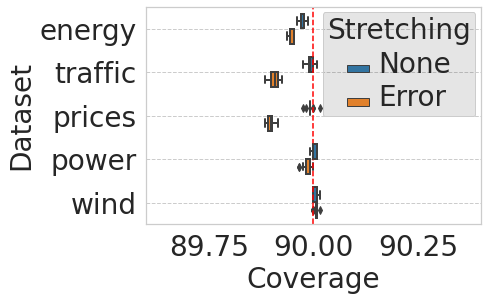

In [15]:
hue_order = ['IdentityPhiFunction - COVERAGE', 'LossAwarePhi - COVERAGE']
labels = ['None', 'Error']
s=sns.boxplot(x="coverage", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.axvline(90, linestyle='--', color='red')
# sns.move_legend(s, "upper left", bbox_to_anchor=(-0.8, 1.02), title='Stretching')
sns.move_legend(s, "upper right", title='Stretching')
plt.xlabel('Coverage', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

legend = s.axes.get_legend()
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.1))
for label, legend_text in zip(labels, legend.get_texts()):
    legend_text.set_text(label)
plt.setp(legend.get_texts(), fontsize=fontsize)
plt.setp(legend.get_title(), fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlim(89.6, 90.4)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)

savefig('real_dataset_plot_coverage')


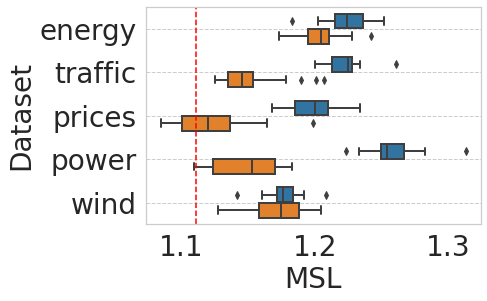

In [16]:
s=sns.boxplot(x="msl", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.axvline(1.111111111111, linestyle='--', color='red')
s.axes.get_legend().remove()
plt.xlabel('MSL', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.ylim(0.89, 0.91)
savefig('real_dataset_plot_msl')

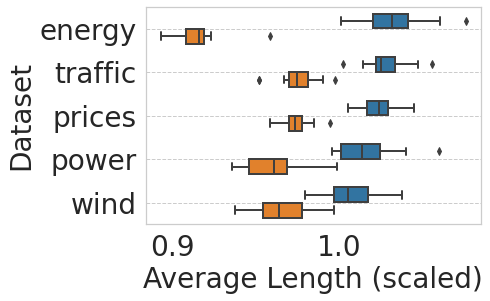

In [17]:
s=sns.boxplot(x="length_mean_normalized", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Average Length (scaled)', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('real_dataset_plot_length')

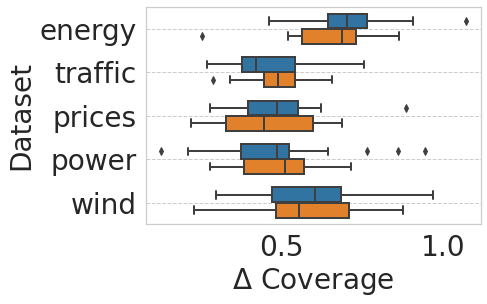

In [18]:
s=sns.boxplot(x="delta_coverage_times_100", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('$\Delta$ Coverage', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('real_dataset_plot_delta_coverage')

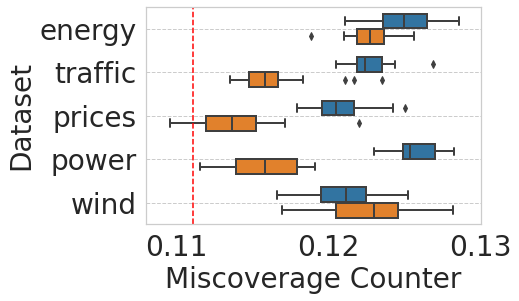

In [19]:
s=sns.boxplot(x="msl2", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.axvline(1/9, linestyle='--', color='red')
s.axes.get_legend().remove()
plt.xlabel('Miscoverage Counter', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlim(0.108, 0.13)
savefig('real_dataset_plot_MC')

# RRC with/without cal

In [20]:
sns.set(rc={'figure.figsize':(10, 4.5)})
sns.set_style("whitegrid", {'axes.grid' : False})

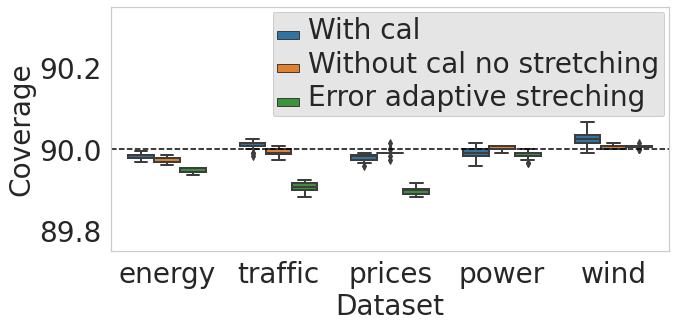

In [21]:
hue_order = ['RCI_with_cal - COVERAGE', 'IdentityPhiFunction - COVERAGE', 'LossAwarePhi - COVERAGE']
labels = ['With cal', 'Without cal no stretching', 'Error adaptive streching']
s=sns.boxplot(x="dataset", y="coverage", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(90, linestyle='--', color='black')
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Coverage', fontsize=fontsize)

legend = s.axes.get_legend()
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.1))
for label, legend_text in zip(labels, legend.get_texts()):
    legend_text.set_text(label)
plt.setp(legend.get_texts(), fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.ylim(89.75, 90.35)
savefig('cal_vs_no_cal_coverage')


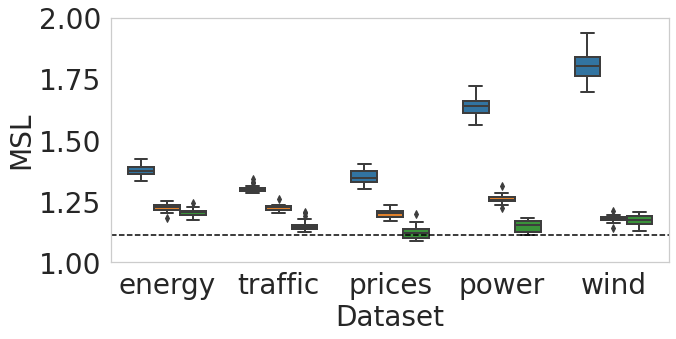

In [22]:
s=sns.boxplot(x="dataset", y="msl", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(1.111111111111, linestyle='--', color='black')
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('MSL', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.ylim(1, 2)
savefig('cal_vs_no_cal_msl')

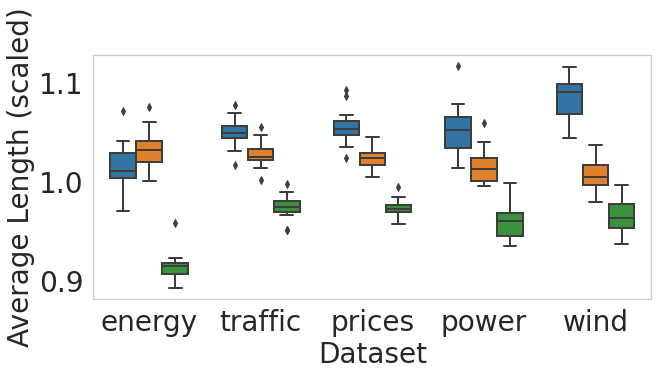

In [23]:
s=sns.boxplot(x="dataset", y="length_mean_normalized", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Average Length (scaled)', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('cal_vs_no_cal_length')

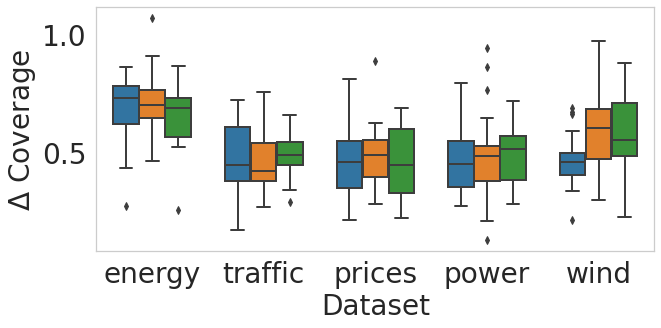

In [24]:
s=sns.boxplot(x="dataset", y="delta_coverage_times_100", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('$\Delta$ Coverage', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('cal_vs_no_cal_delta_coverage')

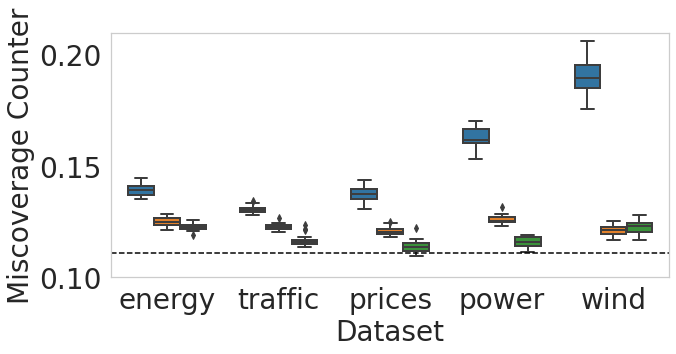

In [25]:
s=sns.boxplot(x="dataset", y="msl2", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(1/9, linestyle='--', color='black')
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Miscoverage Counter', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.ylim(0.1, 0.21)
savefig('cal_vs_no_cal_MC')

# MC risk - stretching vs no stretching

In [26]:
sns.set(rc={'figure.figsize':(6, 6)})
sns.set_style("whitegrid", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--'
})

hue_order = ['IdentityPhiFunction - MSL2', 'LossAwarePhi - MSL2']
labels = ['None', 'Error']

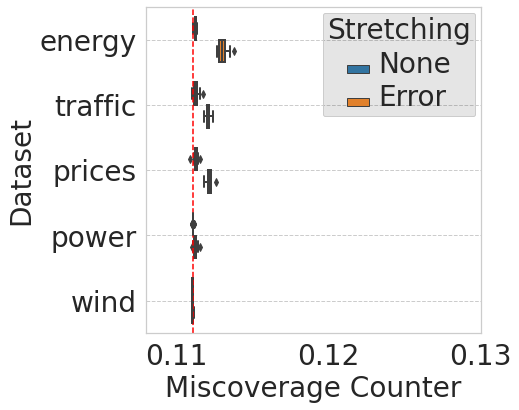

In [27]:
s=sns.boxplot(x="msl2", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.axvline(1/9, linestyle='--', color='red')
sns.move_legend(s, "upper right", title='Stretching')
plt.xlabel('Miscoverage Counter', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

legend = s.axes.get_legend()
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.1))
for label, legend_text in zip(labels, legend.get_texts()):
    legend_text.set_text(label)
plt.setp(legend.get_texts(), fontsize=fontsize)
plt.setp(legend.get_title(), fontsize=fontsize)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlim(0.108, 0.13)

savefig('MC_by_controlling_MC')

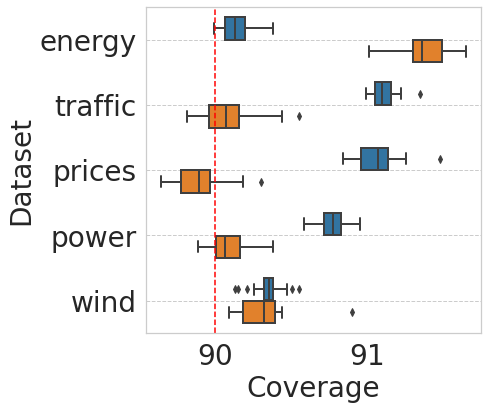

In [28]:
s=sns.boxplot(x="coverage", y="dataset", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.axvline(90, linestyle='--', color='red')
s.axes.get_legend().remove()
plt.xlabel('Coverage', fontsize=fontsize)
plt.ylabel('Dataset', fontsize=fontsize)

s.axes.xaxis.grid(False)
s.axes.yaxis.grid(True)
plt.tick_params(axis='both', which='major', labelsize=fontsize)

savefig('coverage_by_controlling_MC')

# Coverage risk - all methods

In [29]:
sns.set(rc={'figure.figsize':(10, 4.5)})
sns.set_style("whitegrid", {'axes.grid' : False})

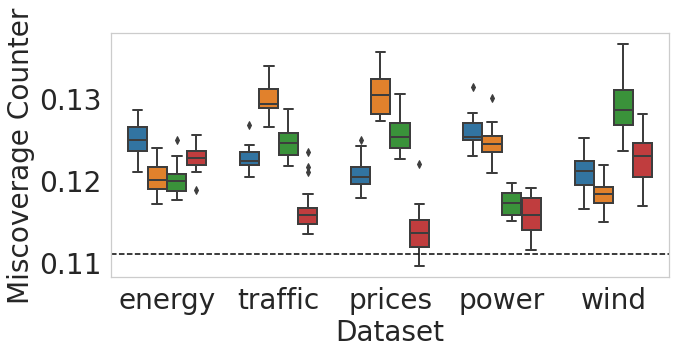

In [30]:
hue_order = ['IdentityPhiFunction - COVERAGE', 'ExpPhiFunction - COVERAGE', 'ScoreAwarePhi - COVERAGE', 'LossAwarePhi - COVERAGE']
labels = ['No streching', 'Exponential streching', 'Score-adaptive streching', 'Error adaptive streching']
s=sns.boxplot(x="dataset", y="msl2", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(1/9, linestyle='--', color='black')
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Miscoverage Counter', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.ylim(0.10, 0.15)

savefig('MC_by_controlling_coverage_all_methods')

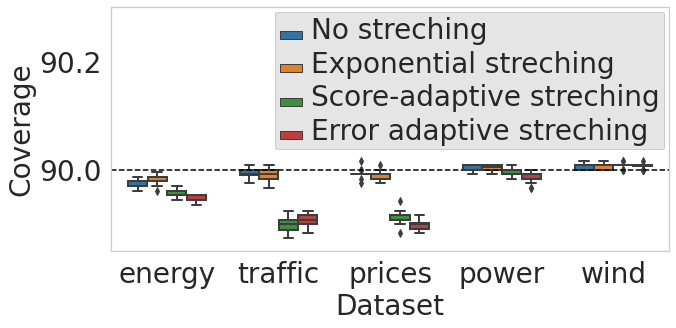

In [31]:
s=sns.boxplot(x="dataset", y="coverage", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(90, linestyle='--', color='black')
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Coverage', fontsize=fontsize)

legend = s.axes.get_legend()
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.1))
for label, legend_text in zip(labels, legend.get_texts()):
    legend_text.set_text(label)

plt.setp(legend.get_texts(), fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.ylim(89.85, 90.3)
savefig('coverage_by_controlling_coverage_all_methods')

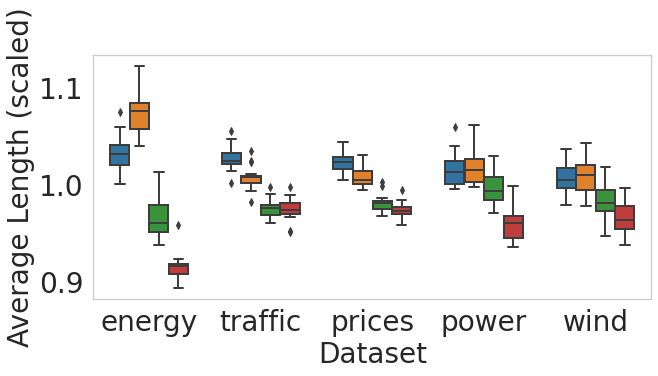

In [32]:
s=sns.boxplot(x="dataset", y="length_mean_normalized", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Average Length (scaled)', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('interval_length_by_controlling_coverage_all_methods')

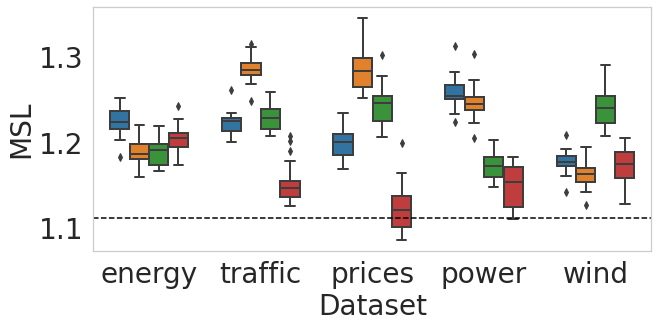

In [33]:
s=sns.boxplot(x="dataset", y="msl", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(10/9, linestyle='--', color='black')
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('MSL', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('MSL_by_controlling_coverage_all_methods')

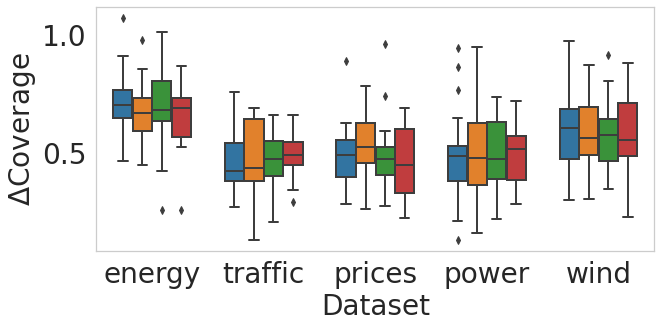

In [34]:
s=sns.boxplot(x="dataset", y="delta_coverage_times_100", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('$\Delta$Coverage', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('delta_coverage_by_controlling_coverage_all_methods')

# MC risk - all methods

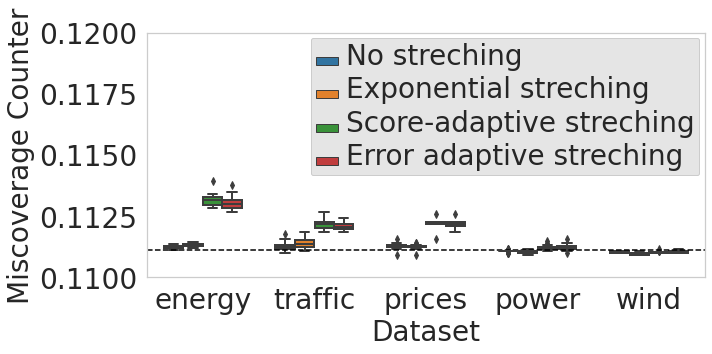

In [35]:
hue_order = ['IdentityPhiFunction - MSL2', 'ExpPhiFunction - MSL2', 'ScoreAwarePhi - MSL2', 'LossAwarePhi - MSL2']
labels = ['No streching', 'Exponential streching', 'Score-adaptive streching', 'Error adaptive streching']
s=sns.boxplot(x="dataset", y="msl2", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(1/9, linestyle='--', color='black')
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Miscoverage Counter', fontsize=fontsize)

legend = s.axes.get_legend()
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.1))
for label, legend_text in zip(labels, legend.get_texts()):
    legend_text.set_text(label)

plt.setp(legend.get_texts(), fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.ylim(0.11, 0.12)

savefig('MC_by_controlling_MC_all_methods')

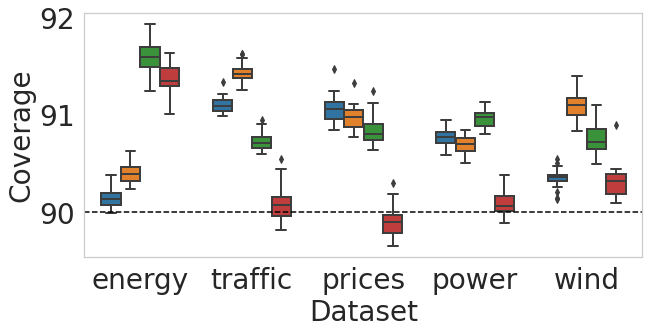

In [36]:
s=sns.boxplot(x="dataset", y="coverage", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(90, linestyle='--', color='black')
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Coverage', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)

savefig('coverage_by_controlling_MC_all_methods')

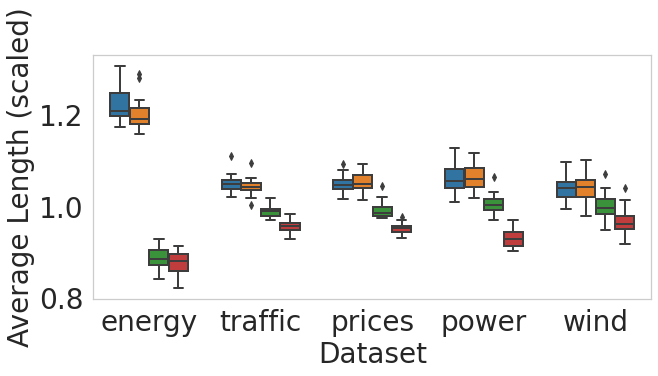

In [37]:
s=sns.boxplot(x="dataset", y="length_mean_normalized", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('Average Length (scaled)', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('interval_length_by_controlling_MC_all_methods')

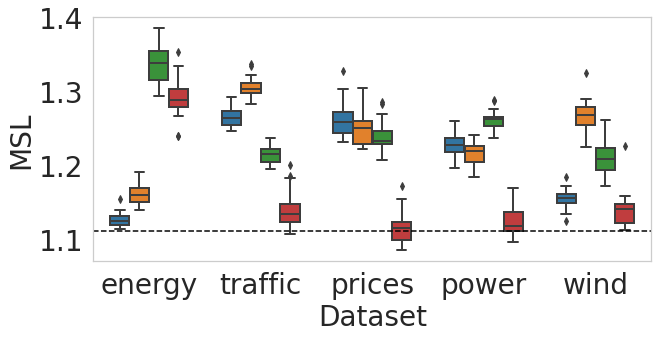

In [38]:
s=sns.boxplot(x="dataset", y="msl", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette).axhline(10/9, linestyle='--', color='black')
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('MSL', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('MSL_by_controlling_MC_all_methods')

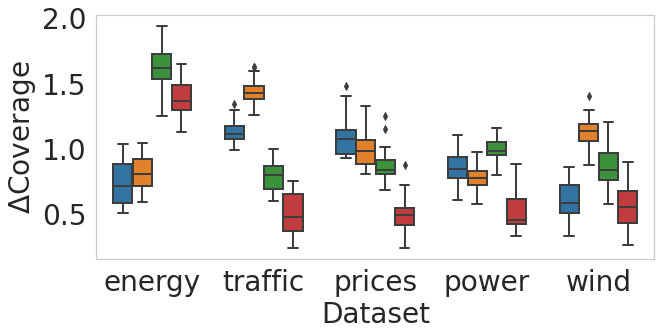

In [39]:
s=sns.boxplot(x="dataset", y="delta_coverage_times_100", data=df2, hue=hue, hue_order=hue_order, linewidth=linewidth, width=0.7, palette=palette)
s.axes.get_legend().remove()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel('$\Delta$Coverage', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=fontsize)
savefig('delta_coverage_by_controlling_MC_all_methods')